In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from numpy import random
from scipy.stats import randint
from scipy.stats import uniform
from scipy import interp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, plot_precision_recall_curve, plot_roc_curve


In [ ]:
csv=pd.read_csv('Churn_Modelling.csv')
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 976.6+ KB


We have 3 unnecessary columns that we need to drop.

In [ ]:
csv=csv.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, errors='ignore')
display(csv.describe(include='all'))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


There are a few features that should be transofromed to categorical. we will do it in a moment.
OK, we are all set to start analyzing the data (while keeping the test set far aside from us...!). We don't want the scaling of the numeric features to get influenced by the test's values.

In [ ]:
train, test = train_test_split(csv, test_size=0.2, stratify=csv['Exited'], random_state=42)
X_train, Y_train=train.drop(['Exited'], axis=1, errors='ignore'), train['Exited']
X_test, Y_test=test.drop(['Exited'], axis=1, errors='ignore'), test['Exited']

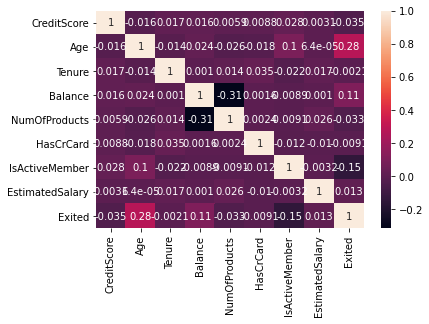

In [ ]:
sns.heatmap(train.corr(), annot=True) # Not an exta-beautiful polished plot, but makes the job done just fine.
plt.show()

Good, No any strong correlation here. Let's have a closer look at the distrubutions and the histograms along the diagonal.

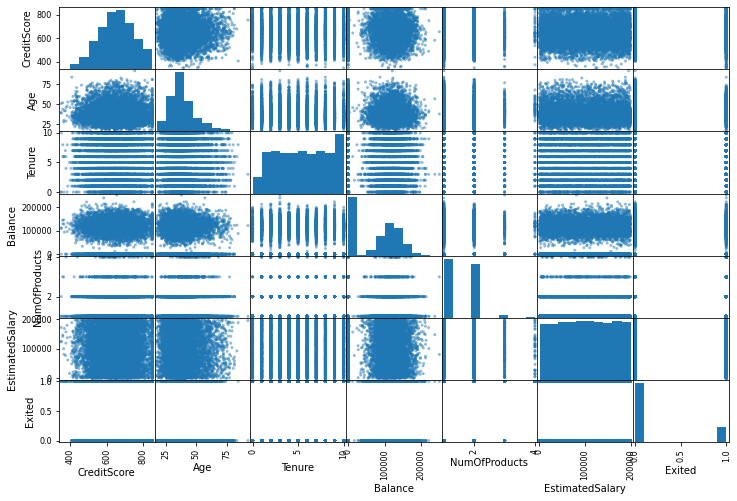

In [ ]:
attributes = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']
scatter_matrix(train[attributes], figsize=(12, 8));

A few conclusions from the scatter matrix:

1. Clearly, there are categorial features currently classified as numeric.
2. We can understand from the target variable 'Exited' that we have an unbalanced dataset. Only 20% are positive (i.e. left the bank). We will use this insight later on.

In [ ]:
# Prepering the data to ML algorithms using pipeline
full_pipeline=ColumnTransformer([
("num", StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']), 
("cat", OneHotEncoder(), ['Geography', 'Gender','HasCrCard',  'IsActiveMember']),
])

X_train_prep=full_pipeline.fit_transform(X_train)
X_train_prep=pd.DataFrame(X_train_prep)
cat_column_name = list(full_pipeline.transformers_[1][1].get_feature_names()) # categorical features names AFTER the transformation
# pasting the corresponding columns names
X_train_prep.columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] +cat_column_name

# ML ALGORITHMS

We have a very IMPORTANT scoring issue here. We will evaluate the models using the 'average_precision' score, which is a good approximation for the PR AUC. It calculates the area under the PR curve, but rather than in the exact continuous manner, it does so in the approximated discrete one. We expect an optimistic results, but the error is systematic and we would be able to calculate the exact PR AUC (and not optimistic) of the chosen model, in order to know how we are doing. Moreover, it's essencial to state that we would have use the ROC AUC if only the dataset wasn't that unbalnced as we saw earlier. In order to get unbiased results, we better use the PR AUC evaluation score.

First, some basic models.

**Linear SVC**

In [ ]:
param_distribs = {
    'penalty' : ['l1', 'l2'],
    'loss' : ['squared_hinge', 'hinge'],
    'C' : uniform(loc=0, scale=4)
    }
LSVC = RandomizedSearchCV(estimator=LinearSVC(dual=False, random_state=42), param_distributions=param_distribs,
                                scoring='average_precision', n_iter=20, cv=4, random_state=42)
LSVC.fit(X_train_prep, Y_train);

print ('Linear SVC')
print ('best_model_params: ', LSVC.best_estimator_.get_params())
print ('best_score_: ', LSVC.best_score_)

e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblin

e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
e:\softwares\python\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  warn

Linear SVC
best_model_params:  {'C': 2.7369321060486276, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}
best_score_:  0.4474709802610925


**Logistic Regression**

In [ ]:
param_distribs = {
    'penalty' : ['l1', 'l2'],
    'C' : uniform(loc=0, scale=4),
    'solver' : ['liblinear'],
    'random_state' : [42]
    }
LogReg = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_distribs,
                                scoring='average_precision', n_iter=20, cv=4, random_state=42)
LogReg.fit(X_train_prep, Y_train);

print ('Logistic Regression')
print ('best_model_params: ', LogReg.best_estimator_)
print ('best_score_: ', LogReg.best_score_)

Logistic Regression
best_model_params:  LogisticRegression(C=3.329770563201687, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best_score_:  0.4543723820528189


Very poor results to both linear estimators. Since the labels are 80-20 biased, accuracy is (unsurprisingly) 81%, though. We should try some more complex, non-linear models- Ensemble Learning. Let's begin with Random Forest.

**Random Forest**

In [ ]:
param_distribs = {
    'max_features': randint(low=3, high=8),
    'min_samples_leaf': uniform(loc=0.005, scale=0.02),
    'n_estimators': randint(low=50, high=200),
    'random_state' : [42]
    }
RF = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_distribs,
                                scoring='average_precision', n_iter=10, cv=4, random_state=42)
RF.fit(X_train_prep, Y_train);
print ('Random Forest')
print ('best_model_params: ', RF.best_estimator_)
print ('best_score_: ', RF.best_score_)

Random Forest
best_model_params:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.006999498316360058,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=137, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
best_score_:  0.6514355939015265


AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

Those are much better result. However, two of the hyper-parameters are currently on the edge of their given range. Running RF again, with a different search this time.

**Random Forest 2**

In [ ]:
param_distribs = {
    'max_features': randint(low=3, high=8),
    'min_samples_leaf': uniform(loc=0.0010, scale=0.0100),
    'n_estimators': randint(low=50, high=200),
    'random_state' : [42]
    }
RF2 = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_distribs,
                                scoring='average_precision', n_iter=20, cv=4, random_state=42)
RF2.fit(X_train_prep, Y_train);
print ('Random Forest 2')
print ('best_model_params: ', RF2.best_estimator_)
print ('best_score_ (average_precision): ', RF2.best_score_)
# Let's have a quick look at how we are doing so far. Test set is still untouched!

Random Forest 2
best_model_params:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.002834045098534338,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=62, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
best_score_ (average_precision):  0.6751000897173365
train_accuracy_score:  0.8742
train_precision:  0.8239202657807309
train_recall:  0.4867517173699706
train_f1_score:  0.6119679210363973
CV_accuracy_score:  0.859
CV_precision:  0.7706896551724138
CV_recall:  0.43866535819430813
CV_f1_score:  0.5590994371482176


In [ ]:
def show_measures(clf, X_train_prep, Y_train):
    y_train_pred=clf.predict(X_train_prep)
    print ('train_accuracy_score: ', accuracy_score(Y_train, y_train_pred)) # Just to show how nonsense would it be setting it as the scoring method...
    print ('train_precision: ', precision_score(Y_train, y_train_pred))
    print ('train_recall: ', recall_score(Y_train, y_train_pred))
    print ('train_f1_score: ', f1_score(Y_train, y_train_pred))
    y_train_pred = cross_val_predict(clf, X_train_prep, Y_train, cv=4)
    print ('CV_accuracy_score: ', accuracy_score(Y_train, y_train_pred)) # Just to show how nonsense would it be setting it as the scoring method...
    print ('CV_precision: ', precision_score(Y_train, y_train_pred))
    print ('CV_recall: ', recall_score(Y_train, y_train_pred))
    print ('CV_f1_score: ', f1_score(Y_train, y_train_pred))
    return y_train_pred

Well, the results aren't brilliant. Could be better if the recall and the precision would somehow switch one with the other. Luckily, **it is possible!** We have quite of a safety gap to reduce the precision by **moving the model's threshold in our favor**. Before doing so, we will continue exploring the data with more models, hoping to get a better classifier, regardless of it's threshold.

**AdaBoost**

In [ ]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42),
                             n_estimators=400, learning_rate=0.5, random_state=42)
AdaBoost.fit(X_train_prep, Y_train);
show_measures(AdaBoost, X_train_prep, Y_train)

train_accuracy_score:  0.8646
train_precision:  0.7697160883280757
train_recall:  0.478900883218842
train_f1_score:  0.5904416212946157
CV_accuracy_score:  0.8516
CV_precision:  0.7134052388289677
CV_recall:  0.45436702649656524
CV_f1_score:  0.5551558752997602


Seems like we have exhusted from the dataset much of what we could have. We will stick with the Random Forest algorithm, and therefore will put even more effort to fine-tune it to the best RF possible.

**Random Forest 3**

In [ ]:
param_distribs = {
    'max_features': randint(low=5, high=10),
    'min_samples_leaf': uniform(loc=0.0005, scale=0.0060),
    'n_estimators': randint(low=50, high=200),
    'random_state' : [42]
    }
RF3 = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_distribs,
                                scoring='average_precision', n_iter=20, cv=4, random_state=42)
RF3.fit(X_train_prep, Y_train);
print ('Random Forest 3')
print ('best_model_params: ', RF3.best_estimator_)
print ('best_score_ (average_precision): ', RF3.best_score_)
# Let's have a quick look at how we are doing so far. Test set is still untouched!
y_pred_cv=show_measures(RF3.best_estimator_, X_train_prep, Y_train)

Random Forest 3
best_model_params:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.0010998494949080173,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=137, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
best_score_ (average_precision):  0.6886591224364091
train_accuracy_score:  0.89225
train_precision:  0.8735408560311284
train_recall:  0.550920245398773
train_f1_score:  0.6756960120391273
CV_accuracy_score:  0.86125
CV_precision:  0.7653061224489796
CV_recall:  0.4601226993865031
CV_f1_score:  0.5747126436781608


#ROC Curve
Running classifier **with cross-validation results** and plotting ROC curves

e:\softwares\python\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


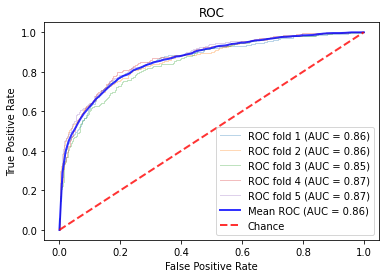

In [ ]:
n_samples, n_features = X_train_prep.shape
cv = StratifiedKFold(n_splits=5, random_state=42)
classifier = RF3.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, val) in enumerate(cv.split(X_train_prep, Y_train)):
    classifier.fit(X_train_prep.iloc[train], Y_train.iloc[train])
    viz = plot_roc_curve(classifier, X_train_prep.iloc[val], Y_train.iloc[val],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr) # using a linear interpolation
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

Looks good. Frankly, though, it is not that good. The ROC Curve points that there is a probability of 85% that a positive instance will get a higher score than a negetive one. Having said that, out dataset is fairly unbalanced (80-20 ratio), hence **we should consider the PR Curve much more**.

# Precision-Recall Curve
Running classifier **with cross-validation results** and plotting PR curves

e:\softwares\python\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


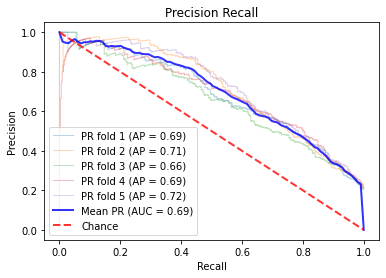

In [ ]:
n_samples, n_features = X_train_prep.shape
cv = StratifiedKFold(n_splits=5, random_state=42)
classifier = RF3.best_estimator_

prcs = []
mean_recall = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, val) in enumerate(cv.split(X_train_prep, Y_train)):
    classifier.fit(X_train_prep.iloc[train], Y_train.iloc[train])
    viz = plot_precision_recall_curve(classifier, X_train_prep.iloc[val], Y_train.iloc[val],
                         name='PR fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1]) # using a linear interpolation
    interp_precision[0] = 1.0
    prcs.append(interp_precision)

mean_precision = np.mean(prcs, axis=0)
mean_precision[-1] = 0.0
mean_auc = auc(mean_recall, mean_precision)
ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AUC = %0.2f)' % (mean_auc), lw=2, alpha=.8)


ax.plot([0, 1], [1, 0], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall")
ax.legend(loc="lower left")
plt.show()
# prc_auc = auc(recalls, precisions)
# print ('prc_auc:', np.round(prc_auc*100, 1), '%')

Given the business goal in the presented dataset problem, we can asume that there is an unequal importancy of recall and precision scores. **Recall is more important**, since we wish, more than anything else, to find the next leaver, i.e diagnose the churn. **Minimizing type 2 error is more important in this case**.

Our model can give us a 70% recall with an approximately 55% precision. **We will choose the corresponding threshold.** Setting the desired threshold of the chosen classifier - Random Forest #3.
Since we are using Random Forest, unlike many others classifiers, it does not have a score function to set the threshold on. We can use the predict_proba method, alternatively.

In [ ]:
y_scores_both_classes=cross_val_predict(classifier, X_train_prep, Y_train,
                                        cv=4, method='predict_proba')
y_scores=y_scores_both_classes[:,1]
# Now, when we have the cross-validated probabilities, we are ready to find the threshold we want.
# Initial setup
recall=1.0 
my_threshold=0
goal_recall=0.70
while recall>goal_recall: # running upwards on thresholds until we get recall<=70%. Should be approx only 30 runs.
    y_pred=(y_scores >= my_threshold).astype('int')
    recall=recall_score(Y_train, y_pred)
    my_threshold+=0.01

print ('threshold: ', np.round(my_threshold, 2))
print ('recall: ', np.round(recall*100, 1), '%')
print ('precision: ', np.round(precision_score(Y_train, y_pred)*100, 1), '%')
print ('f1_final: ', np.round(f1_score(Y_train, y_pred)*100, 1), '%')


threshold:  0.28
recall:  69.7 %
precision:  55.5 %
f1_final:  61.8 %


# Testing

In [ ]:
# X_test_prepared=full_pipeline.fit_transform(X_test)
# X_test_prepared=pd.DataFrame(X_test_prepared)
# cat_column_name = list(full_pipeline.transformers_[1][1].get_feature_names()) # categorical features names AFTER the transformation
# X_test_prepared.columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] +cat_column_name

y_scores=classifier.predict_proba(X_test_prepared)[:,1]
y_pred=(y_scores >= my_threshold).astype('int')

print ('################# TEST #################')
print ('recall: ', np.round(recall_score(Y_test, y_pred)*100, 1), '%')
print ('precision: ', np.round(precision_score(Y_test, y_pred)*100, 1), '%')
print ('f1_final: ', np.round(f1_score(Y_test, y_pred)*100, 1), '%')

recall:  69.3 %
precision:  57.1 %
f1_final:  62.6 %


#To sum up

We have used many different types of ML algorithms, and chose a random forest to be the final classifier.
Throughout the project, we paid attention to other measures than accuracy, and never touched the test set until final evaluation of the model's capabilities.
We have witnessed how misleading the ROC curve can be.
We have reached an f1 score of 62.6% on the test set.
Accuracy is just slightly worse then in others kernels (a few percents less), **but f1 is significantly higher.**